In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Sprawdzenie czy jest GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Używane urządzenie:", device)
print("Urządzenie:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")
# Ścieżki do danych
train_path = 'data/train'
test_path = 'data/test'

# Transformacje
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Mapa klas
label_map = {i: name for i, name in enumerate(train_dataset.classes)}
print("Label map:", label_map)


Używane urządzenie: cpu
Urządzenie: Brak GPU
Label map: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}


In [29]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = EmotionCNN(num_classes=len(label_map)).to(device)


AssertionError: Torch not compiled with CUDA enabled

In [27]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    end = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader.dataset):.4f}, Time: {end - start:.2f} sec")


TypeError: to() received an invalid combination of arguments - got (type), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

evaluate_model(model, test_loader)

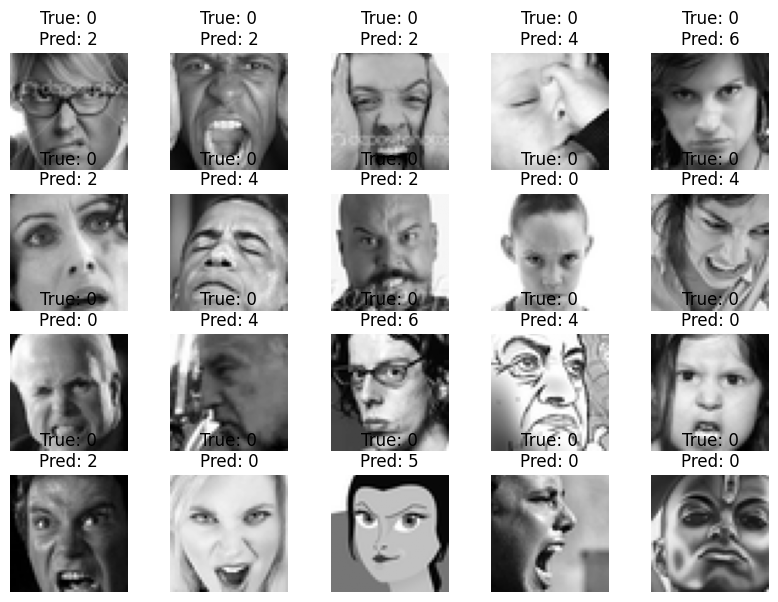

In [14]:
def visualize_predictions(model, dataloader, label_map, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.ravel()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"True: {label_map[labels[i].item()]}\nPred: {label_map[predicted[i].item()]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, label_map)